In [1]:
from data_analysis import *
import numpy as np
import matplotlib.pyplot as plt

class Ca39_MORA_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, -1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 3] #39K + e+ + enu
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
    def kinematical_data(self):
        #energy
        self.data_E_el = self.data[self.names == self.c_lepton ,4]
        
        #directions
        self.data_dir_el = self.data[self.names == self.c_lepton ,5:8]
        self.data_dir_el /= np.tile(np.linalg.norm(self.data_dir_el,axis=1),(3,1)).T
        self.data_dir_enu = self.data[self.names == self.neutrino ,5:8]
        self.data_dir_enu /= np.tile(np.linalg.norm(self.data_dir_enu,axis=1),(3,1)).T
        self.data_dir_K = self.data[self.names == "39K" ,5:8]
        self.data_dir_K /= np.tile(np.linalg.norm(self.data_dir_K,axis=1),(3,1)).T
        
        #angle between e and enu
        self.data_angle_elenu = np.sum(self.data_dir_el*self.data_dir_enu,axis=1) 
        self.data_angle_elK = np.sum(self.data_dir_el*self.data_dir_K,axis=1) 
    def kinematical_data_ref(self,polDir = np.array([0,0,1])):
        #angles in reference to polDir
        z_cross_elenu = np.sum(np.cross(self.data_dir_el,self.data_dir_enu)*polDir[np.newaxis,:],axis=1)
        self.cos_K = np.sum(self.data_dir_K*polDir[np.newaxis,:],axis=1)
        self.cos_el = np.sum(self.data_dir_el*polDir[np.newaxis,:],axis=1)
        self.cos_enu = np.sum(self.data_dir_enu*polDir[np.newaxis,:],axis=1)
        data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)
        data_sinphi = z_cross_elenu
        z_cross_elK = np.sum(np.cross(self.data_dir_el,self.data_dir_K)*polDir[np.newaxis,:],axis=1)
        data_cosphi_K = (self.data_angle_elK-self.cos_el*self.cos_K)
        self.data_phi = np.arctan2(data_sinphi,data_cosphi)
        self.data_phiK = np.arctan2(z_cross_elK,data_cosphi_K)
    def MORA_mask(self,max_abs_cos=1,plotHists=False): #after kin_data_ref
        eq_filter = (np.abs(self.cos_K) < max_abs_cos) & (np.abs(self.cos_el) < max_abs_cos)
        self.phi_el_plane = np.arctan2(self.data_dir_el[:,1],self.data_dir_el[:,0])
        el_det_filter_1 = np.abs(self.phi_el_plane) < np.pi/8 
        el_det_filter_2 = np.abs(self.phi_el_plane-np.pi/2) < np.pi/8
        el_det_filter_3 = np.abs(self.phi_el_plane+np.pi/2) < np.pi/8 
        el_det_filter_4 = np.abs(self.phi_el_plane) > 7*np.pi/8
        el_det_filter = (el_det_filter_1 | el_det_filter_2) | (el_det_filter_3 | el_det_filter_4)
        self.phi_K_plane = np.arctan2(self.data_dir_K[:,1],self.data_dir_K[:,0])
        K_det_filter_1 = np.abs(self.phi_K_plane-np.pi/4) < np.pi/8
        K_det_filter_2 = np.abs(self.phi_K_plane+np.pi/4) < np.pi/8
        K_det_filter_3 = np.abs(self.phi_K_plane-3*np.pi/4) < np.pi/8
        K_det_filter_4 = np.abs(self.phi_K_plane+3*np.pi/4) < np.pi/8
        K_det_filter = (K_det_filter_1 | K_det_filter_2) | (K_det_filter_3 | K_det_filter_4)
        full_mask = np.logical_and(eq_filter,np.logical_and(el_det_filter,K_det_filter))
        self.data_dir_el = self.data_dir_el[full_mask,:]
        self.data_dir_enu = self.data_dir_enu[full_mask,:]
        self.data_dir_K = self.data_dir_K[full_mask,:]
        self.data_angle_elenu = self.data_angle_elenu[full_mask]
        self.data_angle_elK = self.data_angle_elK[full_mask]
        self.data_E_el = self.data_E_el[full_mask]
    def plot_mask_hists(self):
        fig, ax = plt.subplots()
        ax.hist(self.data_phiK*180/np.pi,bins=100)
        ax.set_xticks(np.linspace(-180,180,9),np.linspace(-180,180,9))
        ax.set_xlabel("$\\phi_K$",size = 16)
        ax.set_ylabel('Counts',size = 16)
        plt.show()
        plt.scatter(self.data_dir_el[:,0],self.data_dir_el[:,1],s=1)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.plot(np.linspace(-1,1,9)*np.cos(np.pi/8),np.linspace(-1,1,9)*np.sin(np.pi/8),color="grey")
        plt.plot(np.linspace(-1,1,9)*np.cos(-np.pi/8),np.linspace(-1,1,9)*np.sin(-np.pi/8),color="grey")
        plt.plot(np.linspace(-1,1,9)*np.cos(3*np.pi/8),np.linspace(-1,1,9)*np.sin(3*np.pi/8),color="grey")
        plt.plot(np.linspace(-1,1,9)*np.cos(-3*np.pi/8),np.linspace(-1,1,9)*np.sin(-3*np.pi/8),color="grey")
        plt.xlabel("$x_e$",size = 16)
        plt.ylabel('$y_e$',size = 16)
        plt.show()
        plt.scatter(self.data_dir_K[:,0],self.data_dir_K[:,1],s=1)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.plot(np.linspace(-1,1,9)*np.cos(np.pi/8),np.linspace(-1,1,9)*np.sin(np.pi/8),color="grey")
        plt.plot(np.linspace(-1,1,9)*np.cos(-np.pi/8),np.linspace(-1,1,9)*np.sin(-np.pi/8),color="grey")
        plt.plot(np.linspace(-1,1,9)*np.cos(3*np.pi/8),np.linspace(-1,1,9)*np.sin(3*np.pi/8),color="grey")
        plt.plot(np.linspace(-1,1,9)*np.cos(-3*np.pi/8),np.linspace(-1,1,9)*np.sin(-3*np.pi/8),color="grey")
        plt.xlabel("$x_K$",size = 16)
        plt.ylabel('$y_K$',size = 16)
        plt.show()

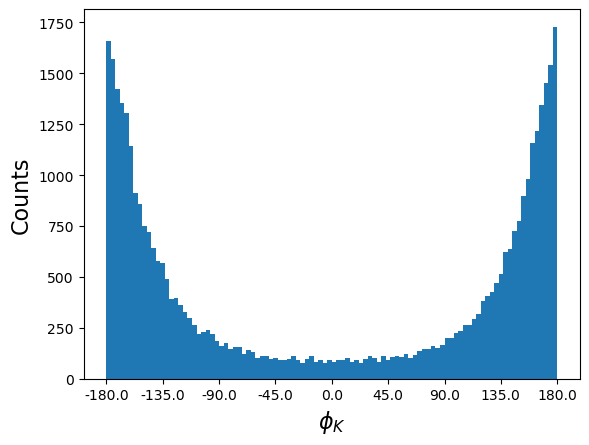

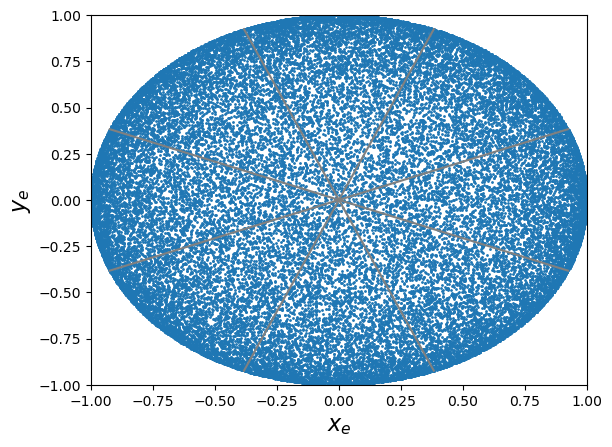

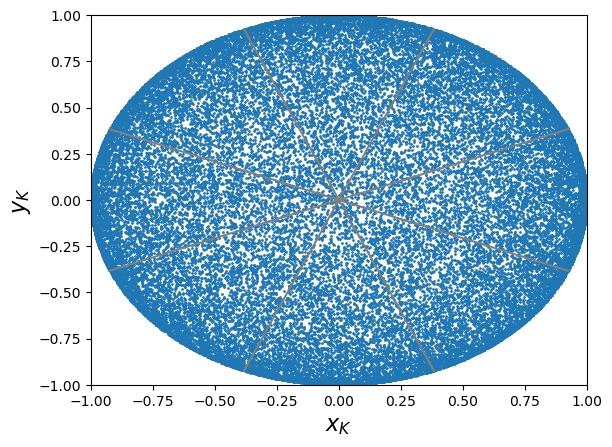

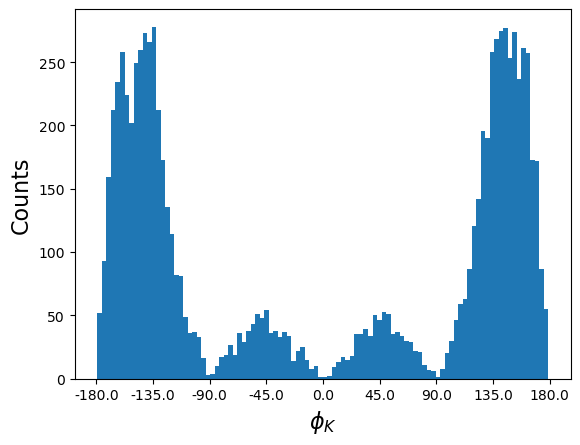

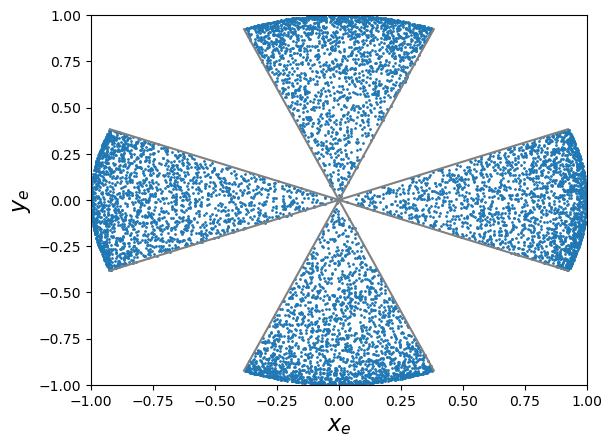

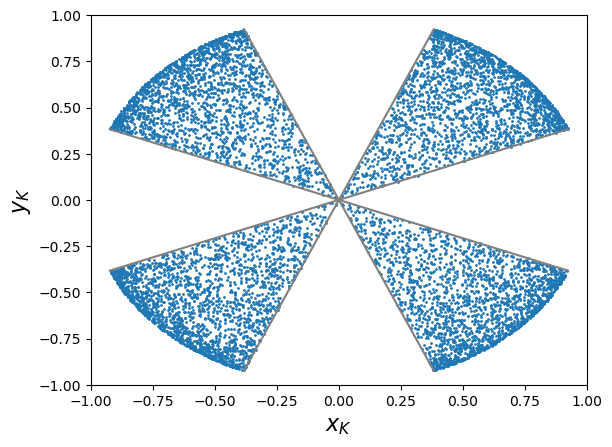

8860


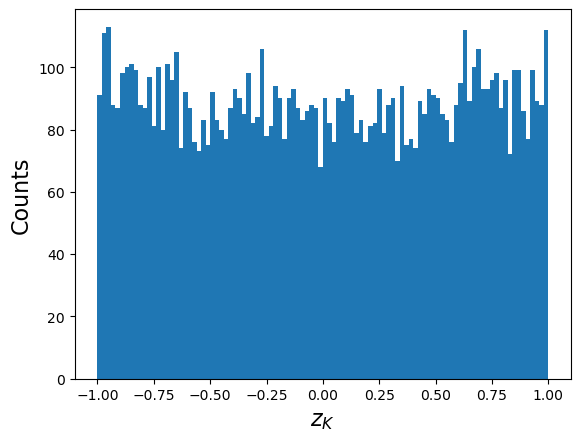

In [2]:
test_analysis = Ca39_MORA_data_analysis("build/39Ca_Mora_test.txt")
test_analysis.event_mask()
test_analysis.kinematical_data()
test_analysis.kinematical_data_ref()
test_analysis.plot_mask_hists()
test_analysis.MORA_mask()
test_analysis.kinematical_data_ref()
test_analysis.plot_mask_hists()
print(getattr(test_analysis,"data_E_el").size)


cos_K = getattr(test_analysis,"cos_K")
fig, ax = plt.subplots()
ax.hist(cos_K,bins=100)
ax.set_xlabel("$z_K$",size = 16)
ax.set_ylabel('Counts',size = 16)
plt.show()

0.0
0.9198025792708234
0.9198025792708234


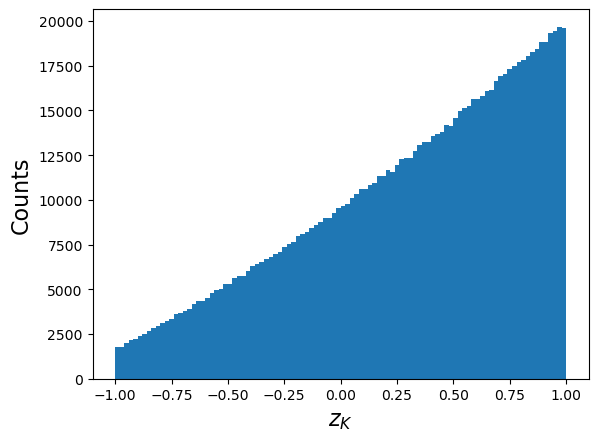

19878
0.28212093772009256


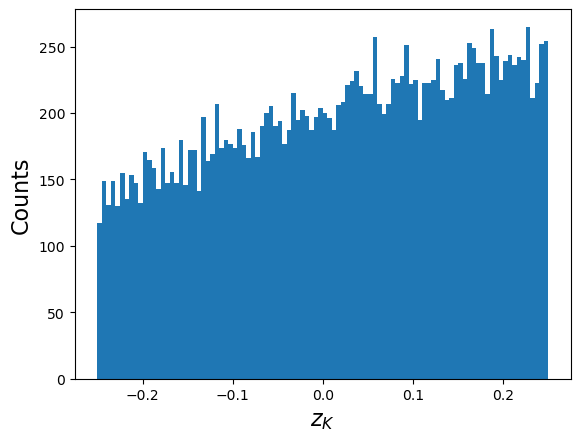

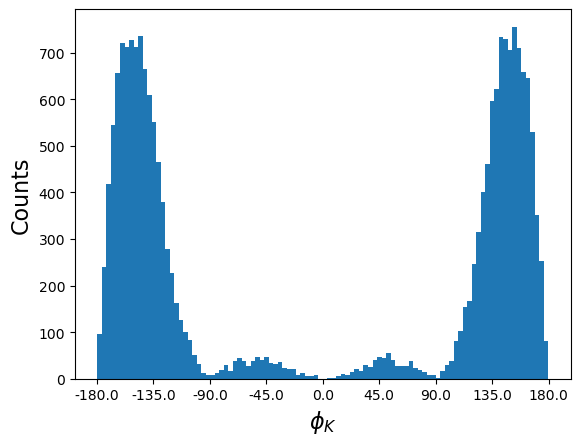

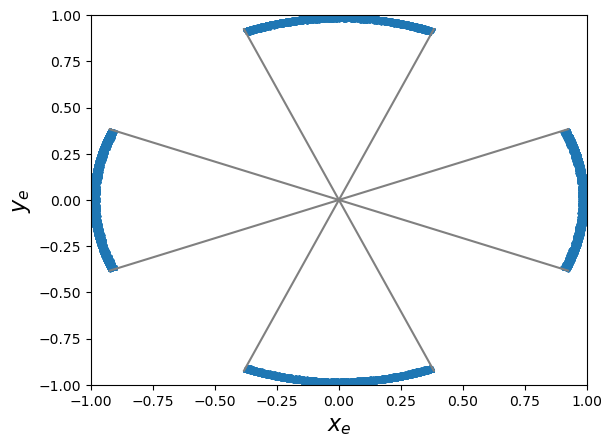

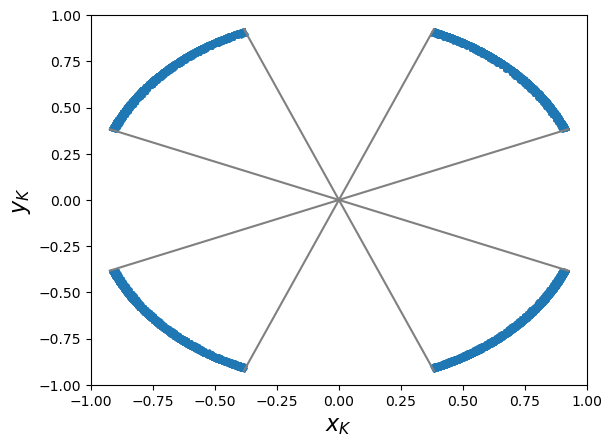

12.0
0.8982056528635348
0.9182721014596381


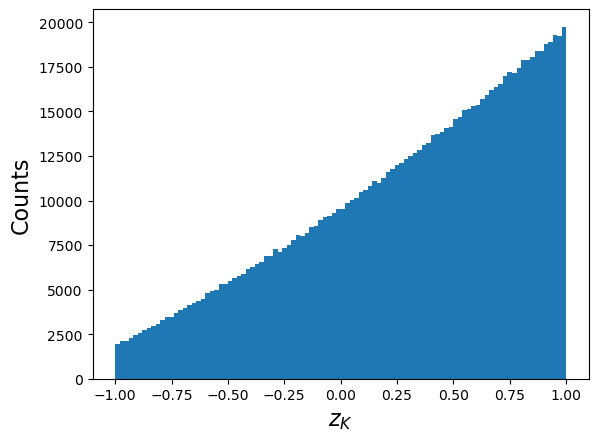

19774
0.2579144330939618


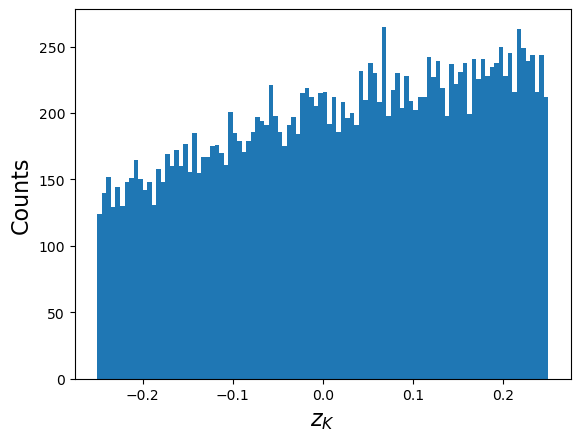

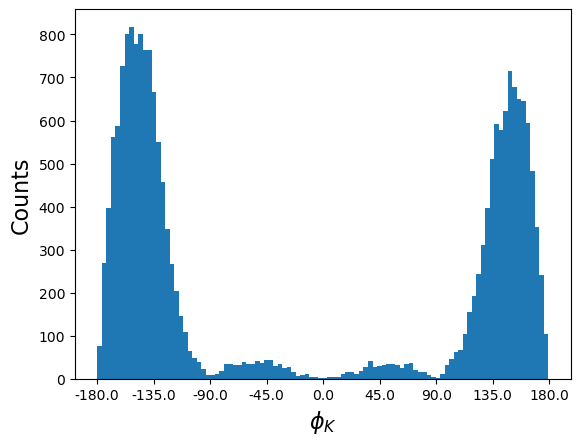

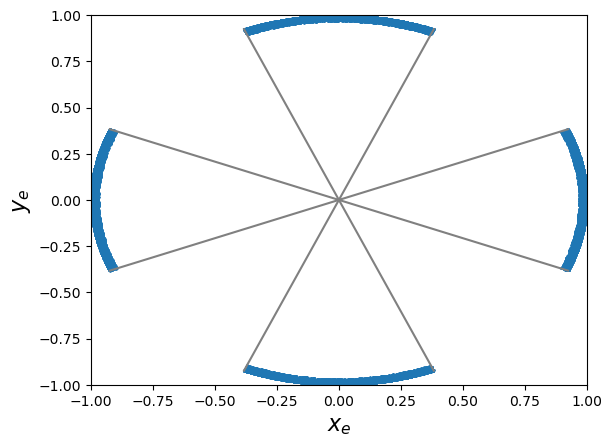

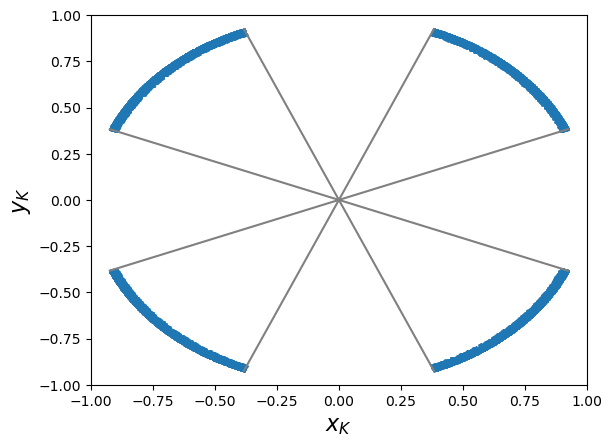

24.0
0.8422798051824664
0.9219900314057331


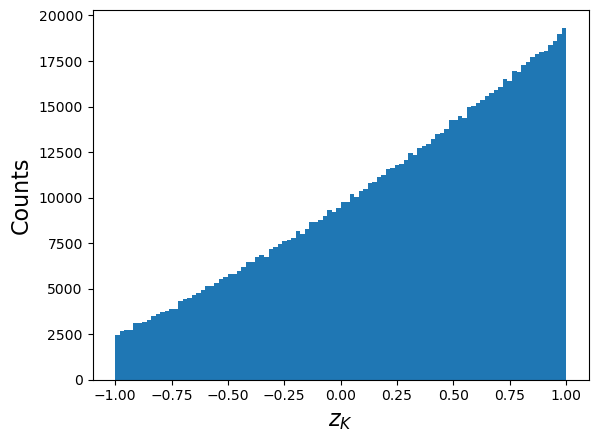

20157
0.2566850225728035


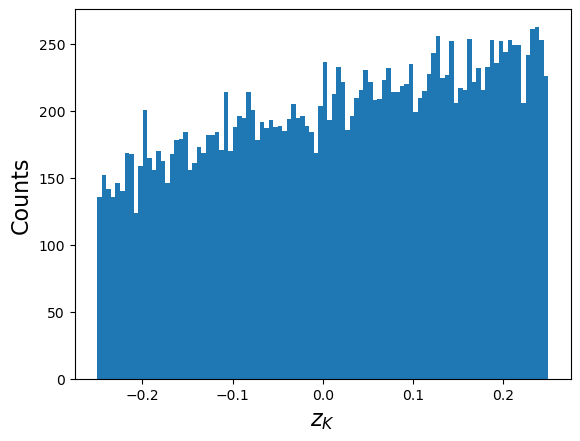

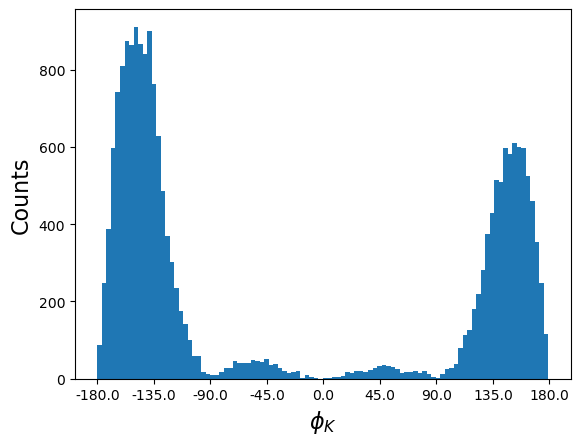

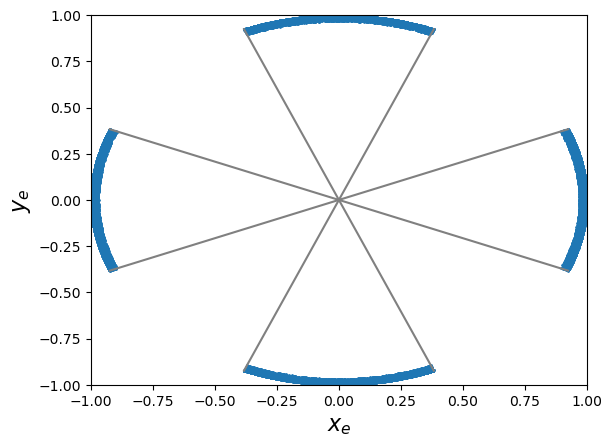

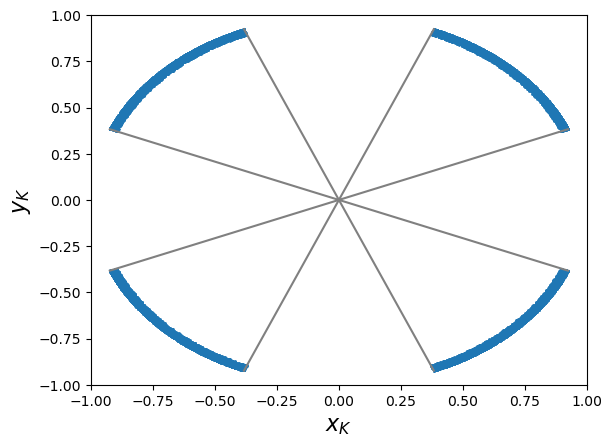

37.0
0.7356182056385074
0.9210937860688743


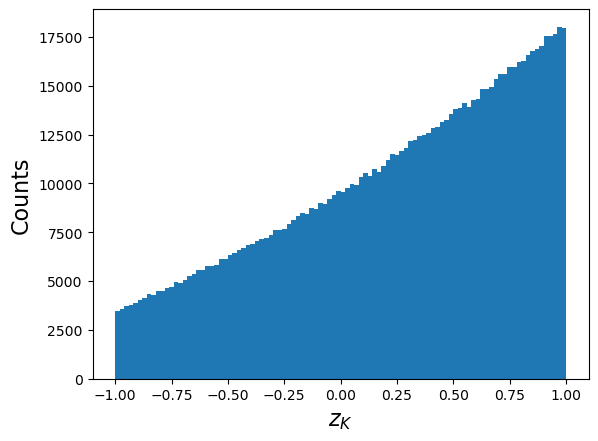

19928
0.22721798474508229


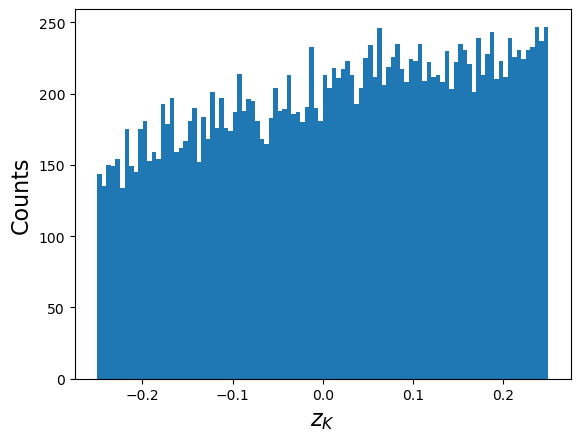

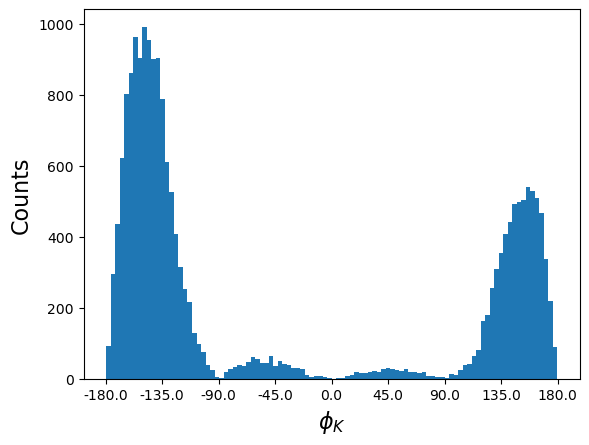

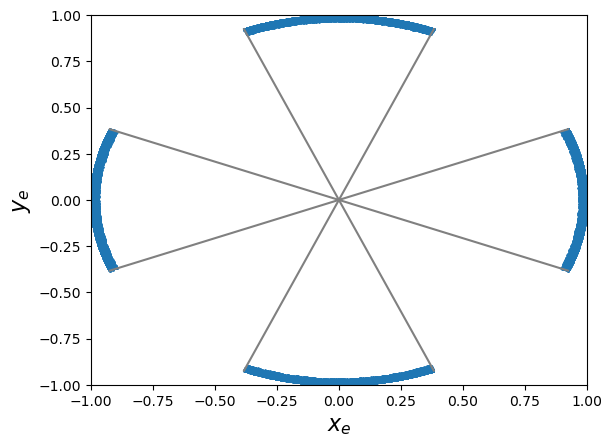

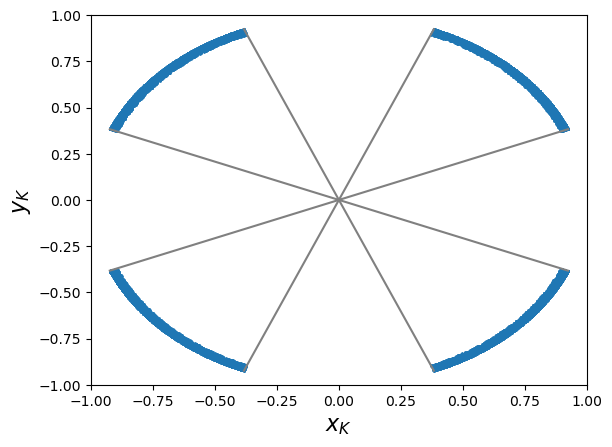

53.0
0.5663801069698412
0.9411199208743339


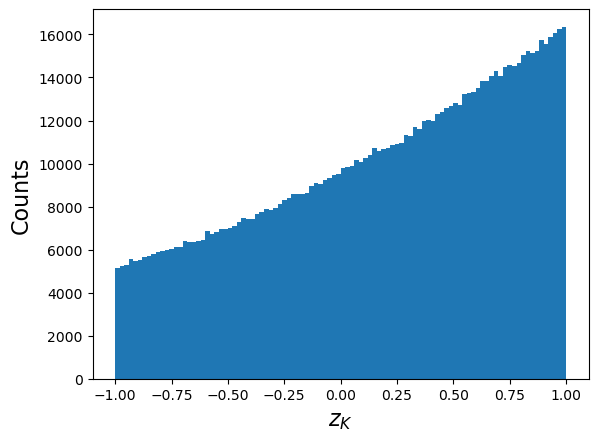

20128
0.19058028616852146


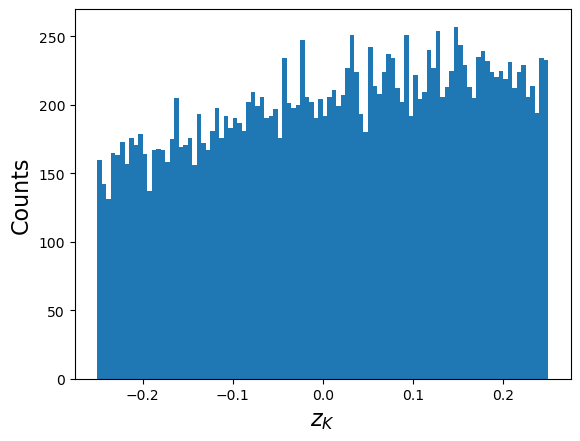

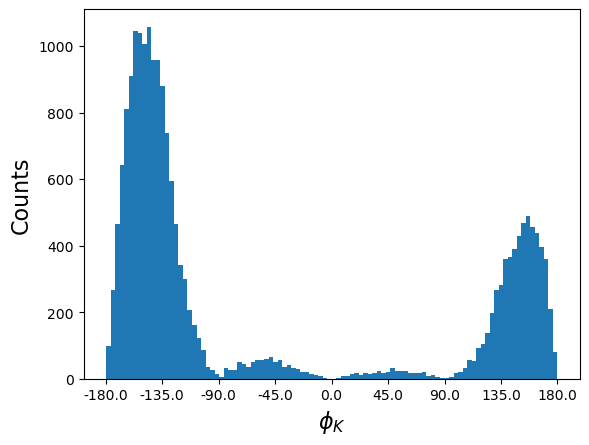

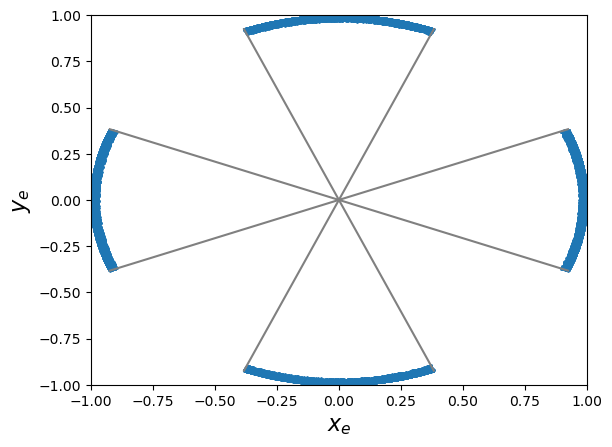

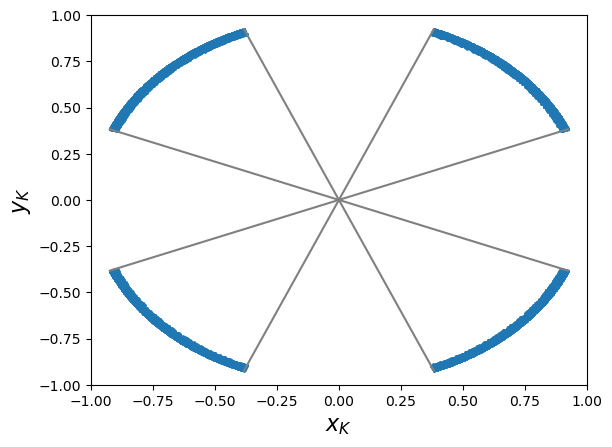

90.0
0.024339874170311113


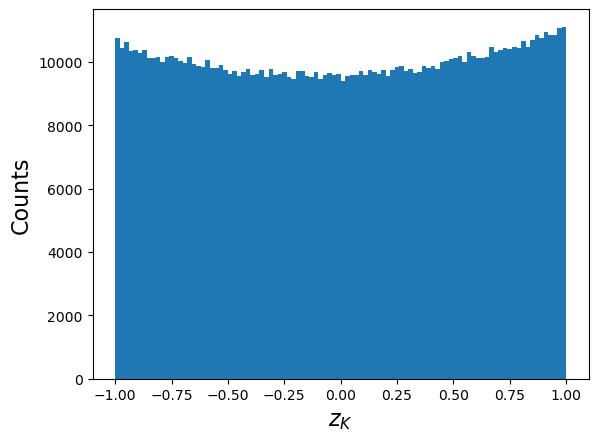

19921
0.04447567893178053


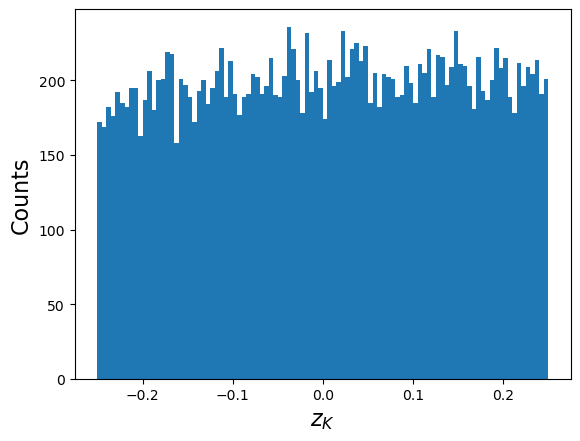

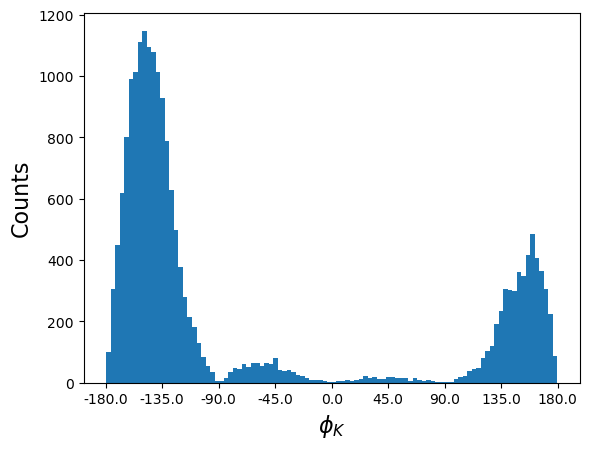

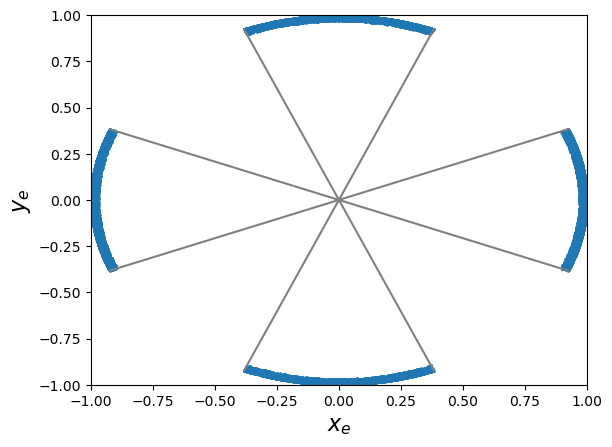

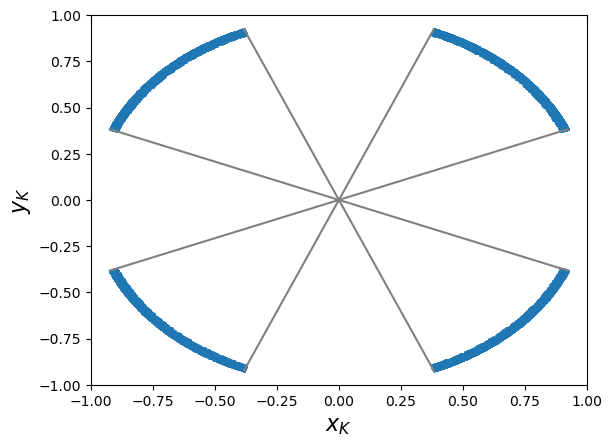

In [3]:
ang_list = np.around(np.arcsin(np.linspace(0,1,6))*180/np.pi)
triple_corr_exp = np.zeros_like(ang_list)
triple_corr_err = np.zeros_like(ang_list)
A_rec_assym = np.zeros_like(ang_list)

for i, ang in enumerate(ang_list):
    print(ang)
    MORA_sim_39Ca = Ca39_MORA_data_analysis(f"build/39Ca_MORA_ang_{ang}.txt")
    MORA_sim_39Ca.event_mask()
    MORA_sim_39Ca.kinematical_data()
    MORA_sim_39Ca.kinematical_data_ref()
    cos_K = getattr(MORA_sim_39Ca,"cos_K")
    A_rec_assym[i] = (np.sum(cos_K > 0)-np.sum(cos_K < 0))*2/cos_K.size
    print(A_rec_assym[i])
    if ang != 90:
        print(A_rec_assym[i]/np.cos(ang*np.pi/180))
    fig, ax = plt.subplots()
    ax.hist(cos_K,bins=100)
    ax.set_xlabel("$z_K$",size = 16)
    ax.set_ylabel('Counts',size = 16)
    plt.show()
    MORA_sim_39Ca.MORA_mask(max_abs_cos=0.25)
    MORA_sim_39Ca.kinematical_data_ref()
    cos_K = getattr(MORA_sim_39Ca,"cos_K")
    print(cos_K.size)
    fig, ax = plt.subplots()
    ax.hist(cos_K,bins=100)
    ax.set_xlabel("$z_K$",size = 16)
    ax.set_ylabel('Counts',size = 16)
    print((np.sum(cos_K > 0)-np.sum(cos_K < 0))*2/cos_K.size)
    plt.show()
    MORA_sim_39Ca.plot_mask_hists()
    triple_corr_exp[i] = (np.sum(getattr(MORA_sim_39Ca,"data_phiK") > 0)-
                      np.sum(getattr(MORA_sim_39Ca,"data_phiK") < 0))
    triple_corr_exp[i] /= -getattr(MORA_sim_39Ca,"data_phi").size
    triple_corr_err[i] = 1/np.sqrt(getattr(MORA_sim_39Ca,"data_phi").size)

0.9716745537908948 0.20284413692442074 0.0281316686245547
[6.92479043e-01 3.01097832e-04] [0.01194248 0.00516662]


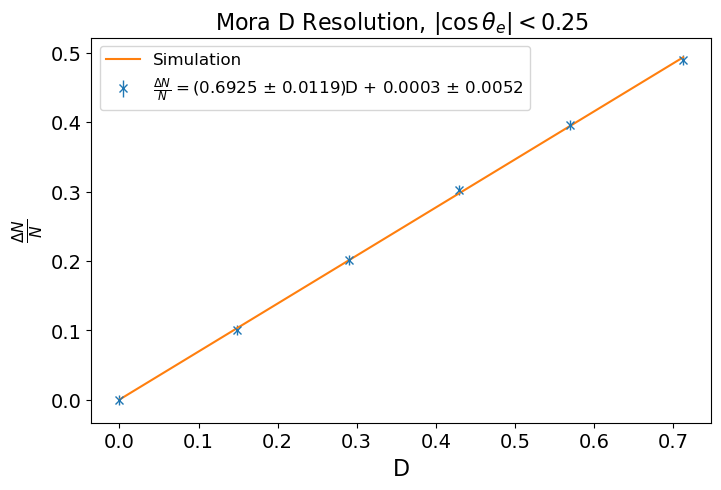

In [4]:
from scipy.optimize import curve_fit

#for both
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

mgt_Ca = 0.6606 #includes norm(c_a)

#calculation of <beta>
W_0 = 5502.5/mass_e + 1
E_range = np.linspace(mass_e+0.1,5502.5+mass_e,6000)
dist_E = []
av_beta_Ca = 0
av_inversegamma = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,19,39)
    dist_E.append(dist)
    av_beta_Ca += dist*np.sqrt(1-1/W**2)
    av_inversegamma += dist/W
dist_E = np.array(dist_E)
av_beta_Ca /= dist_E.sum()
av_inversegamma /= dist_E.sum()

print(av_beta_Ca,av_inversegamma,av_inversegamma*19/137)

D = mgt_Ca*np.sin(ang_list*np.pi/180)*4*sqrt_jj/(2+2*mgt_Ca**2)

def f(x,a,b):
    return a*x+b

param, param_cov = curve_fit(f,D,triple_corr_exp,sigma=triple_corr_err,absolute_sigma=True)
param_err = np.sqrt(np.diag(param_cov))

print(param,param_err)

label = "$\\frac {\\Delta N}{N} = ($" + f"{param[0]:0.4f}" + " $\\pm$ " + f"{param_err[0]:0.4f})D + "
label += f"{param[1]:0.4f}" + " $\\pm$ " + f"{param_err[1]:0.4f}"



fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title("Mora D Resolution, $|\\cos \\theta_e| < 0.25$",size=16)
ax.errorbar(D,triple_corr_exp,yerr=triple_corr_err,label=label,
            marker="x",linewidth=0,elinewidth=1)
ax.plot(D,param[0]*D+param[1],label="Simulation")
ax.set_xlabel("D",size=16)
ax.set_ylabel("$\\frac {\\Delta N}{N}$",size=16)
ax.tick_params("both",labelsize=14)
ax.legend(fontsize=12)

0.0


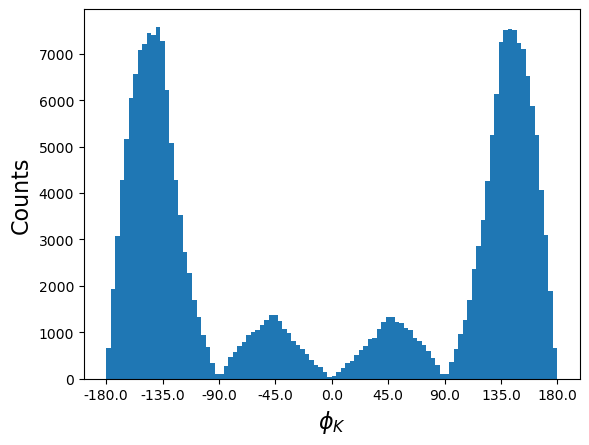

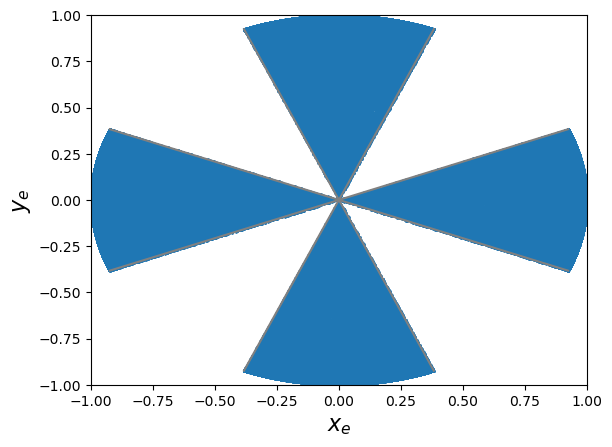

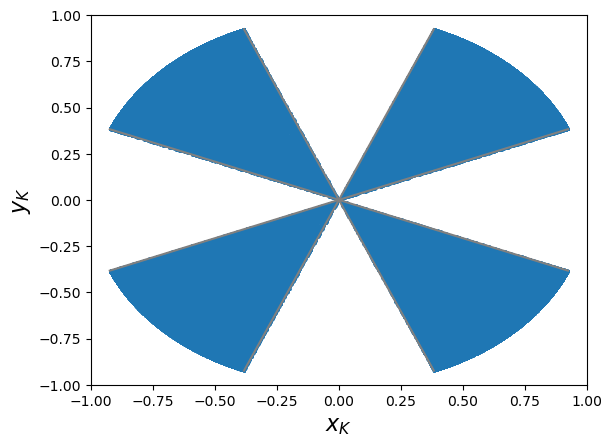

12.0


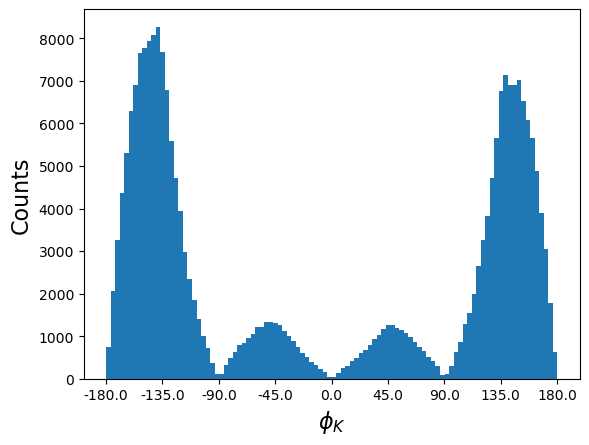

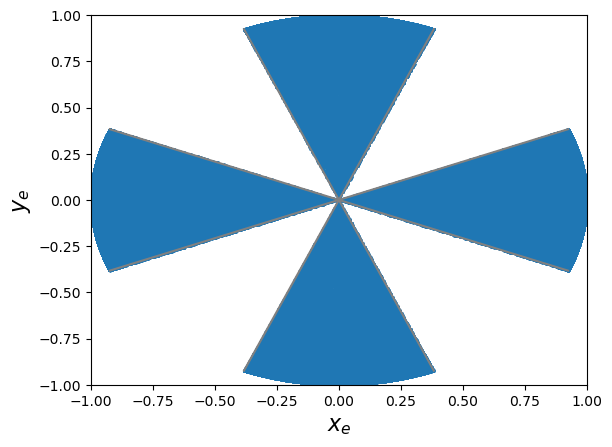

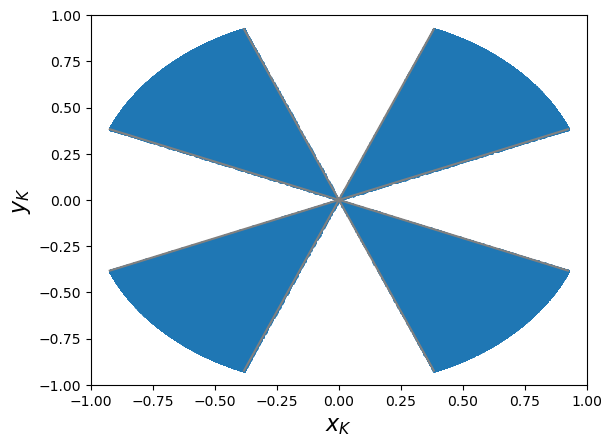

24.0


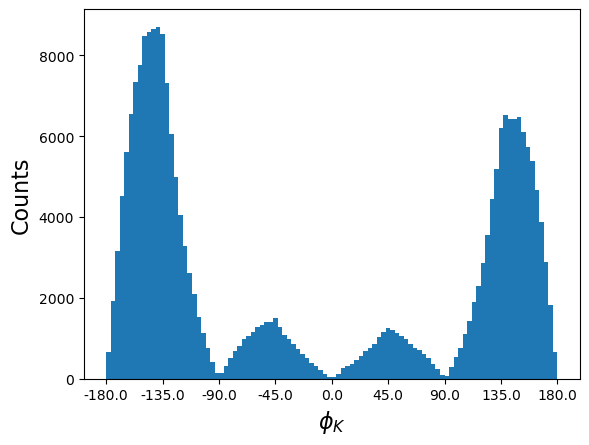

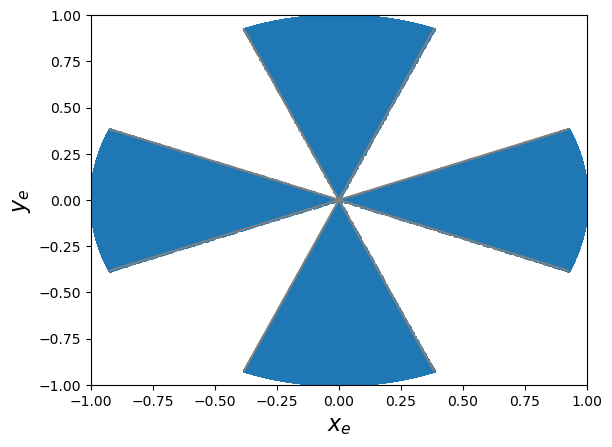

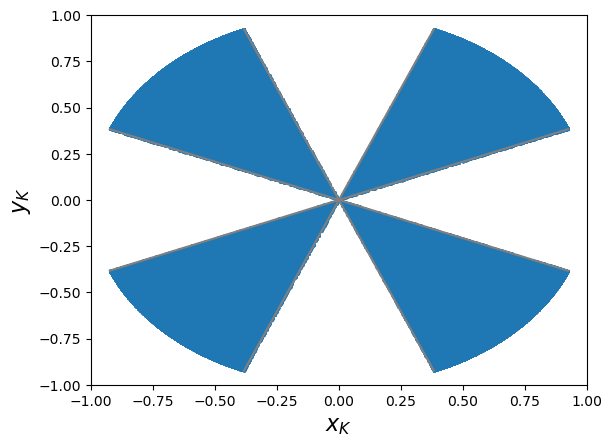

37.0


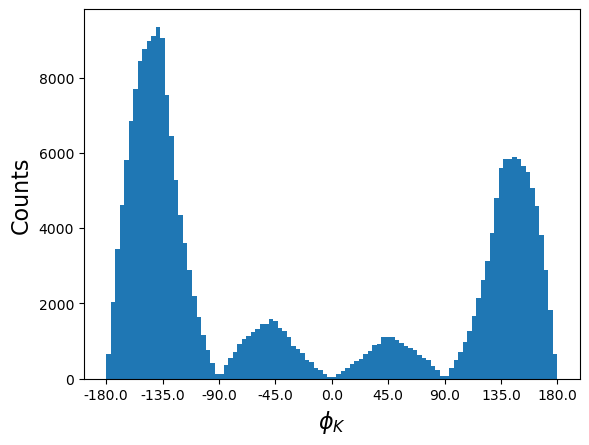

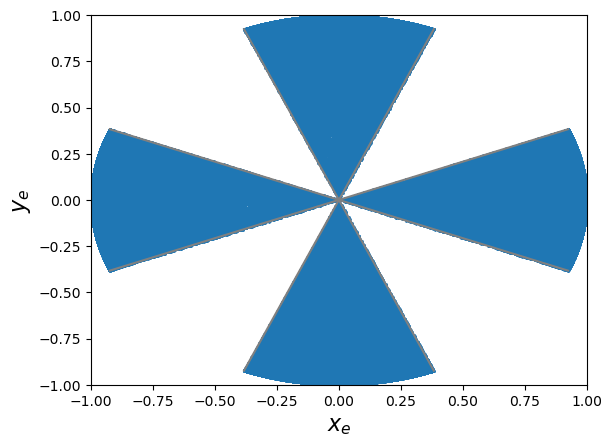

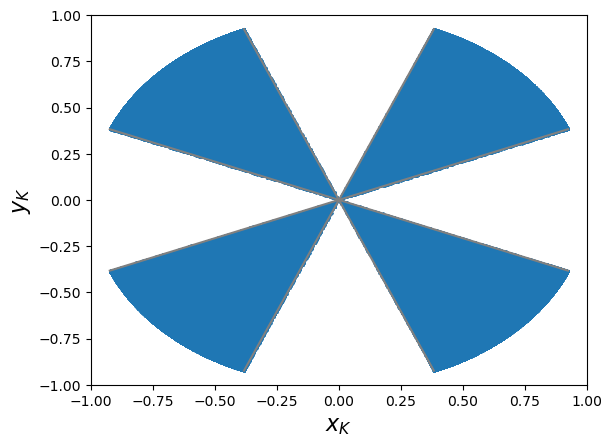

53.0


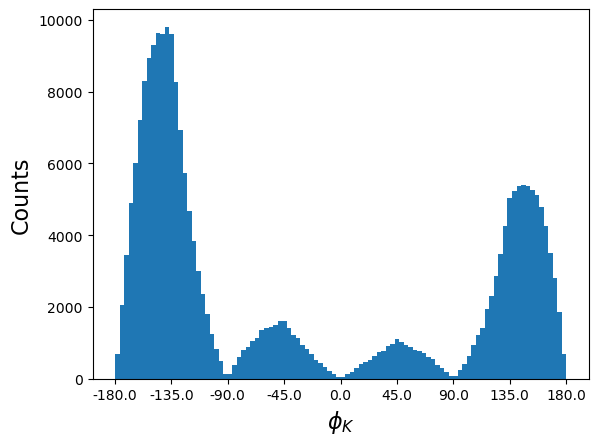

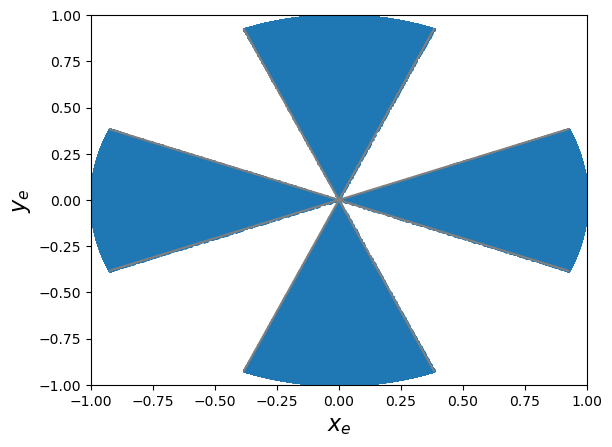

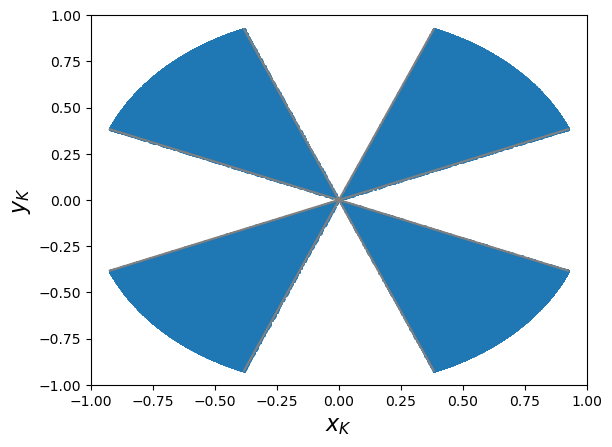

90.0


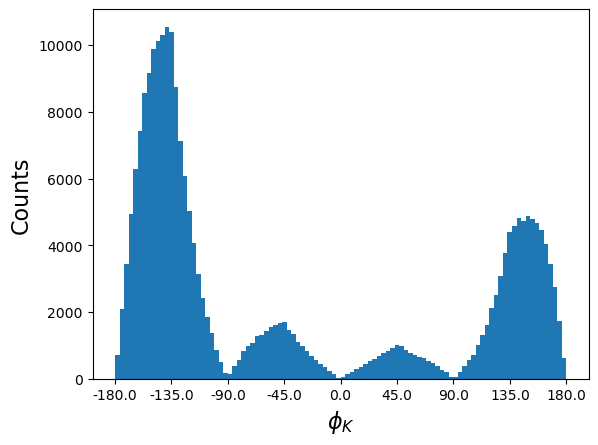

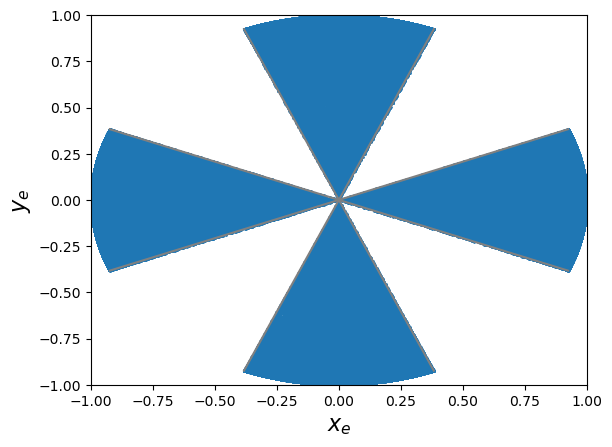

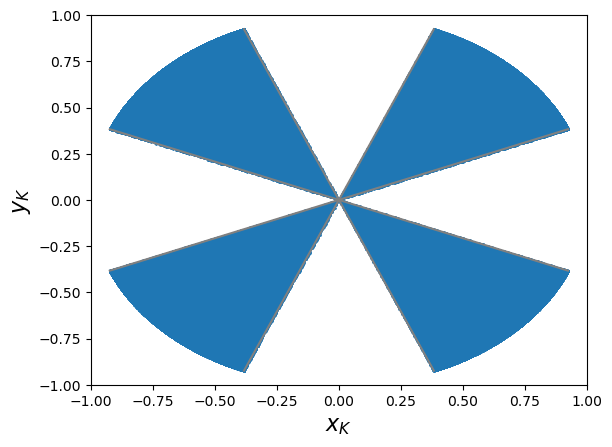

In [5]:
ang_list = np.around(np.arcsin(np.linspace(0,1,6))*180/np.pi)
triple_corr_exp = np.zeros_like(ang_list)
triple_corr_err = np.zeros_like(ang_list)

for i, ang in enumerate(ang_list):
    print(ang)
    MORA_sim_39Ca = Ca39_MORA_data_analysis(f"build/39Ca_MORA_ang_{ang}.txt")
    MORA_sim_39Ca.event_mask()
    MORA_sim_39Ca.kinematical_data()
    MORA_sim_39Ca.kinematical_data_ref()
    MORA_sim_39Ca.MORA_mask(max_abs_cos=1)
    MORA_sim_39Ca.kinematical_data_ref()
    MORA_sim_39Ca.plot_mask_hists()
    triple_corr_exp[i] = (np.sum(getattr(MORA_sim_39Ca,"data_phiK") > 0)-
                      np.sum(getattr(MORA_sim_39Ca,"data_phiK") < 0))
    triple_corr_exp[i] /= -getattr(MORA_sim_39Ca,"data_phi").size
    triple_corr_err[i] = 1/np.sqrt(getattr(MORA_sim_39Ca,"data_phi").size)

0.9716745537908948 0.20284413692442074 0.0281316686245547
[ 0.45450034 -0.00116018] [0.00345121 0.00149252]


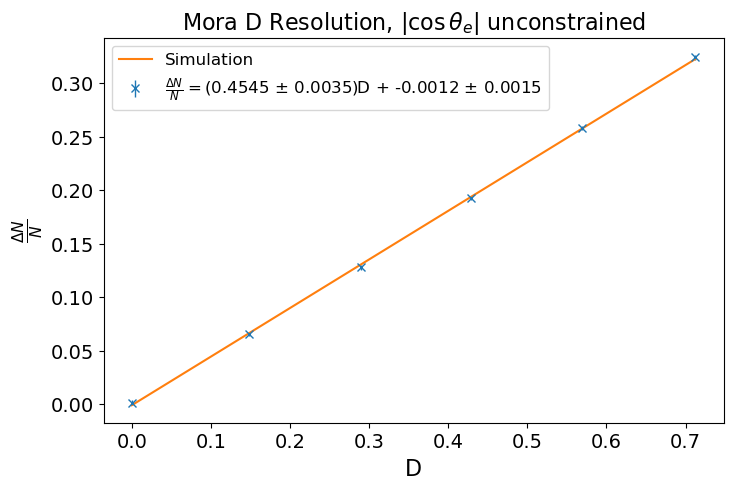

In [6]:
from scipy.optimize import curve_fit

#for both
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

mgt_Ca = 0.6606 #includes norm(c_a)

#calculation of <beta>
W_0 = 5502.5/mass_e + 1
E_range = np.linspace(mass_e+0.1,5502.5+mass_e,6000)
dist_E = []
av_beta_Ca = 0
av_inversegamma = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,19,39)
    dist_E.append(dist)
    av_beta_Ca += dist*np.sqrt(1-1/W**2)
    av_inversegamma += dist/W
dist_E = np.array(dist_E)
av_beta_Ca /= dist_E.sum()
av_inversegamma /= dist_E.sum()

print(av_beta_Ca,av_inversegamma,av_inversegamma*19/137)

D = mgt_Ca*np.sin(ang_list*np.pi/180)*4*sqrt_jj/(2+2*mgt_Ca**2)

def f(x,a,b):
    return a*x+b

param, param_cov = curve_fit(f,D,triple_corr_exp,sigma=triple_corr_err,absolute_sigma=True)
param_err = np.sqrt(np.diag(param_cov))

print(param,param_err)

label = "$\\frac {\\Delta N}{N} = ($" + f"{param[0]:0.4f}" + " $\\pm$ " + f"{param_err[0]:0.4f})D + "
label += f"{param[1]:0.4f}" + " $\\pm$ " + f"{param_err[1]:0.4f}"

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title("Mora D Resolution, $|\\cos \\theta_e|$ unconstrained",size=16)
ax.errorbar(D,triple_corr_exp,yerr=triple_corr_err,label=label,
            marker="x",linewidth=0,elinewidth=1)
ax.plot(D,param[0]*D+param[1],label="Simulation")
ax.set_xlabel("D",size=16)
ax.set_ylabel("$\\frac {\\Delta N}{N}$",size=16)
ax.tick_params("both",labelsize=14)
ax.legend(fontsize=12)

0.0


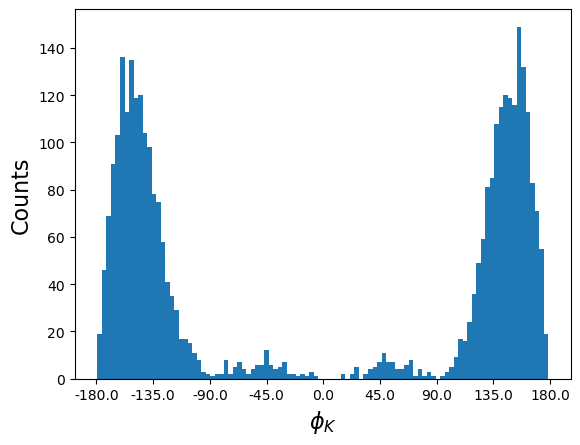

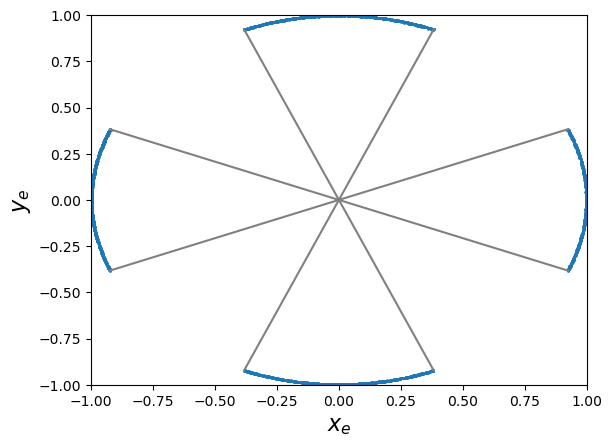

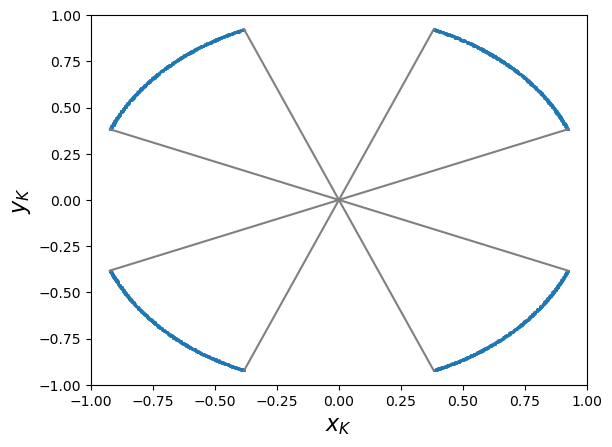

12.0


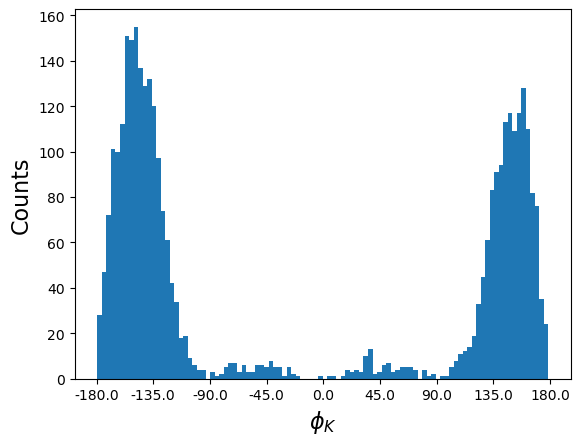

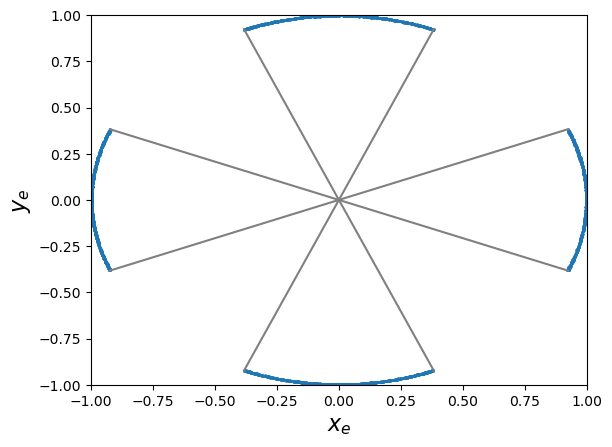

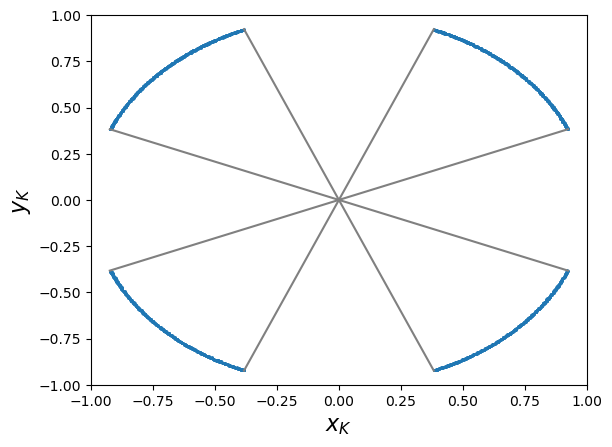

24.0


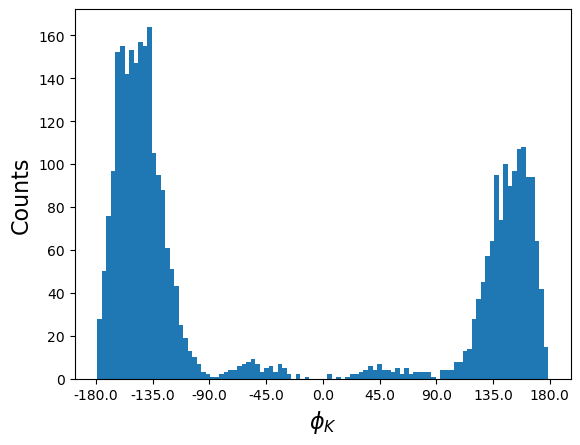

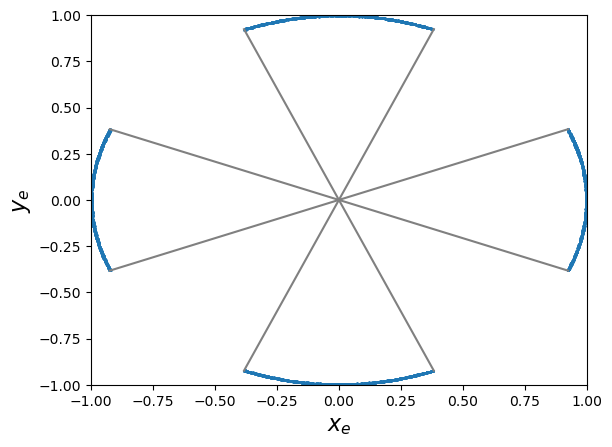

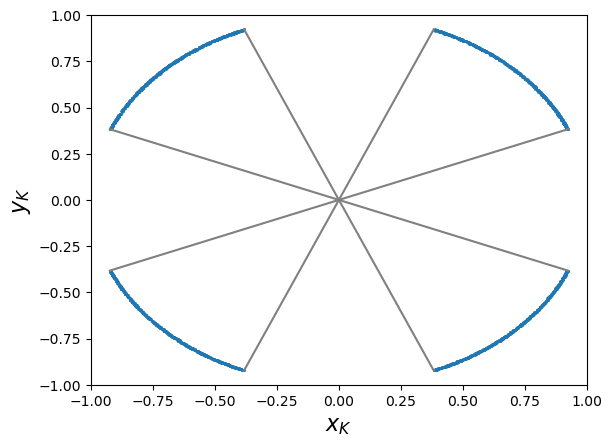

37.0


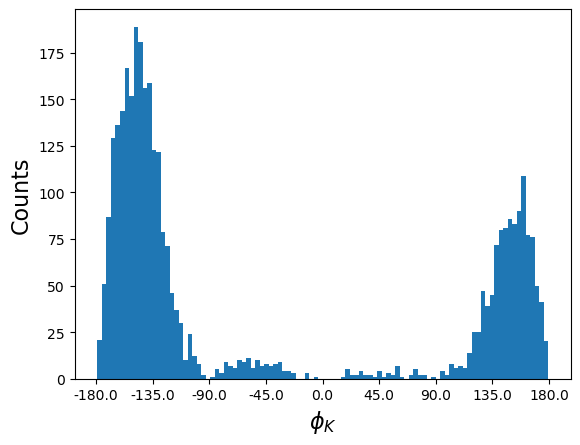

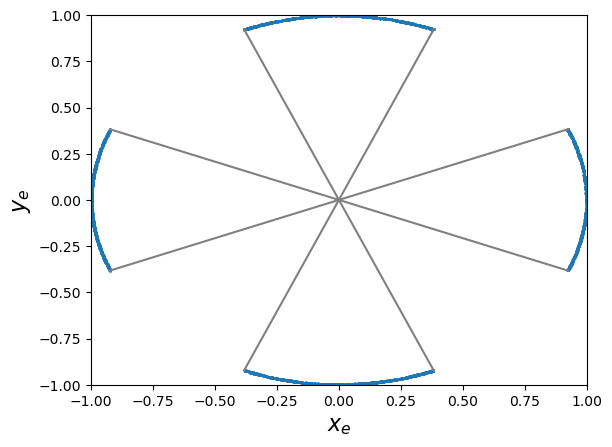

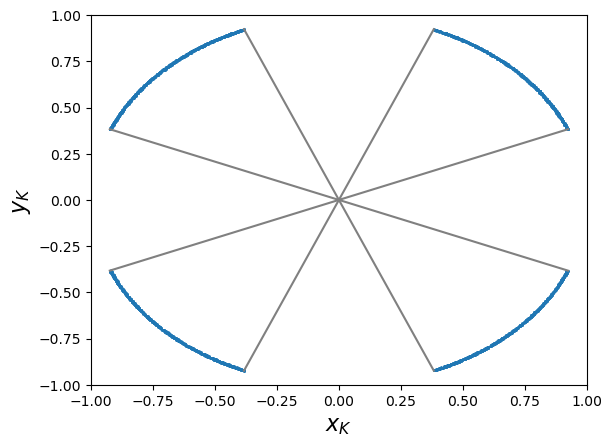

53.0


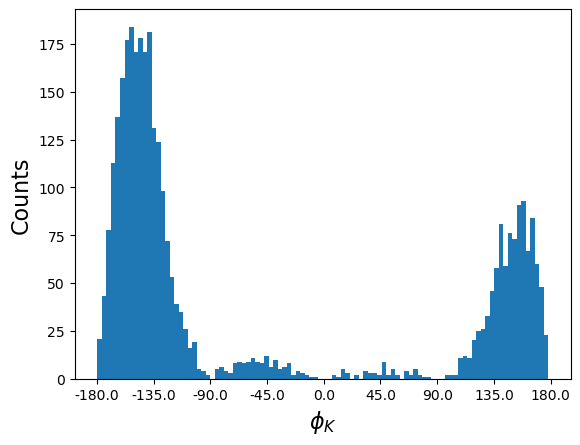

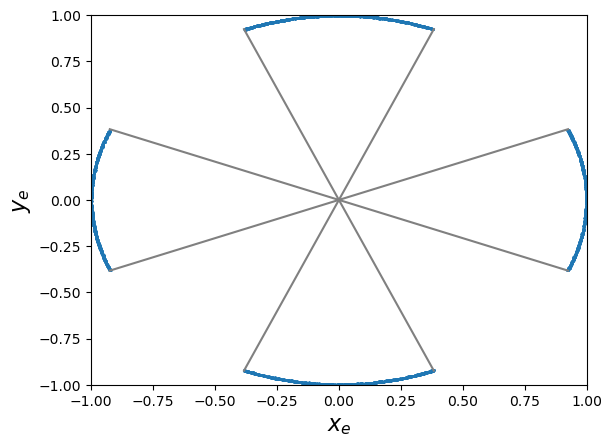

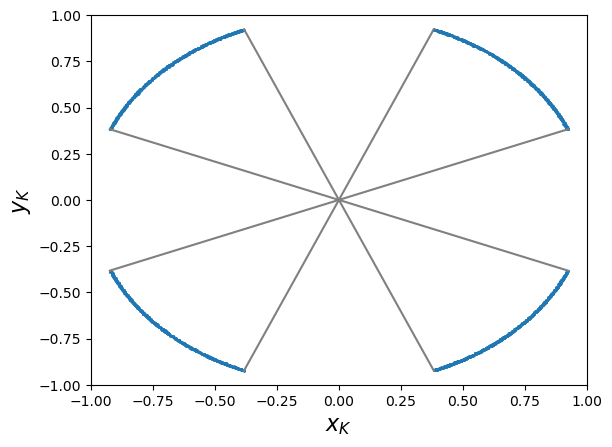

90.0


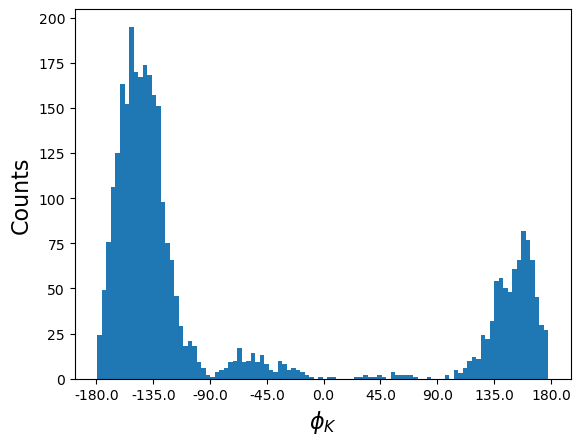

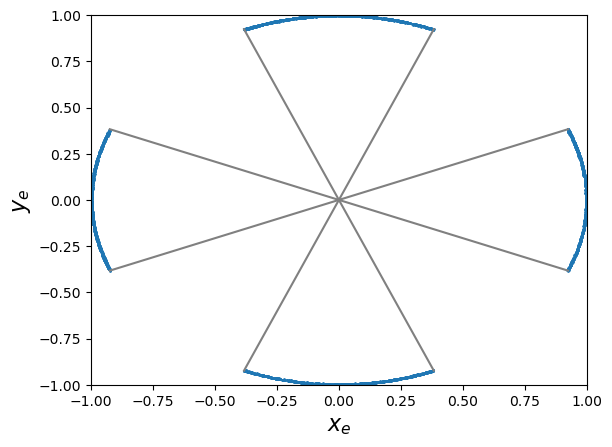

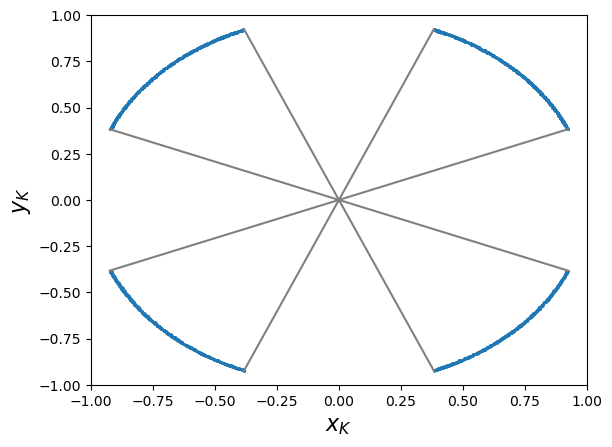

In [7]:
ang_list = np.around(np.arcsin(np.linspace(0,1,6))*180/np.pi)
triple_corr_exp = np.zeros_like(ang_list)
triple_corr_err = np.zeros_like(ang_list)

for i, ang in enumerate(ang_list):
    print(ang)
    MORA_sim_39Ca = Ca39_MORA_data_analysis(f"build/39Ca_MORA_ang_{ang}.txt")
    MORA_sim_39Ca.event_mask()
    MORA_sim_39Ca.kinematical_data()
    MORA_sim_39Ca.kinematical_data_ref()
    MORA_sim_39Ca.MORA_mask(max_abs_cos=0.1)
    MORA_sim_39Ca.kinematical_data_ref()
    MORA_sim_39Ca.plot_mask_hists()
    triple_corr_exp[i] = (np.sum(getattr(MORA_sim_39Ca,"data_phiK") > 0)-
                      np.sum(getattr(MORA_sim_39Ca,"data_phiK") < 0))
    triple_corr_exp[i] /= -getattr(MORA_sim_39Ca,"data_phi").size
    triple_corr_err[i] = 1/np.sqrt(getattr(MORA_sim_39Ca,"data_phi").size)

0.9716745537908948 0.20284413692442074 0.0281316686245547
[0.6923099  0.00894615] [0.02928929 0.01262118]


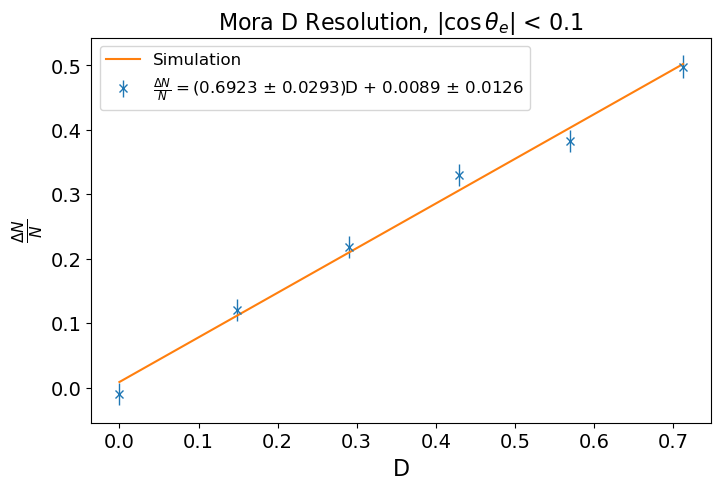

In [8]:
from scipy.optimize import curve_fit

#for both
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

mgt_Ca = 0.6606 #includes norm(c_a)

#calculation of <beta>
W_0 = 5502.5/mass_e + 1
E_range = np.linspace(mass_e+0.1,5502.5+mass_e,6000)
dist_E = []
av_beta_Ca = 0
av_inversegamma = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,19,39)
    dist_E.append(dist)
    av_beta_Ca += dist*np.sqrt(1-1/W**2)
    av_inversegamma += dist/W
dist_E = np.array(dist_E)
av_beta_Ca /= dist_E.sum()
av_inversegamma /= dist_E.sum()

print(av_beta_Ca,av_inversegamma,av_inversegamma*19/137)

D = mgt_Ca*np.sin(ang_list*np.pi/180)*4*sqrt_jj/(2+2*mgt_Ca**2)

def f(x,a,b):
    return a*x+b

param, param_cov = curve_fit(f,D,triple_corr_exp,sigma=triple_corr_err,absolute_sigma=True)
param_err = np.sqrt(np.diag(param_cov))

print(param,param_err)

label = "$\\frac {\\Delta N}{N} = ($" + f"{param[0]:0.4f}" + " $\\pm$ " + f"{param_err[0]:0.4f})D + "
label += f"{param[1]:0.4f}" + " $\\pm$ " + f"{param_err[1]:0.4f}"

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title("Mora D Resolution, $|\\cos \\theta_e|$ < 0.1",size=16)
ax.errorbar(D,triple_corr_exp,yerr=triple_corr_err,label=label,
            marker="x",linewidth=0,elinewidth=1)
ax.plot(D,param[0]*D+param[1],label="Simulation")
ax.set_xlabel("D",size=16)
ax.set_ylabel("$\\frac {\\Delta N}{N}$",size=16)
ax.tick_params("both",labelsize=14)
ax.legend(fontsize=12)

In [9]:
mgt_Ca = 0.6606
lambda_jj = 4/5
Lambda_jj = -1
sqrt_jj = np.sqrt(3/5)

def CVCA_phase_39Ca(E):
    xi = 2*(1+mgt_Ca**2)
    a = 2*(1-mgt_Ca**2/3)
    b = 0
    c = 2*Lambda_jj*mgt_Ca**2
    A = 2*lambda_jj*mgt_Ca**2-4*sqrt_jj*mgt_Ca*cos_ca
    B = -2*lambda_jj*mgt_Ca**2-4*sqrt_jj*mgt_Ca*cos_ca
    D = 4*mgt_Ca*sqrt_jj*sin_ca
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

for a in np.linspace(0,1,11):
    cos_ca = a
    sin_ca = np.sqrt(1-a**2)
    A, B = CVCA_phase_39Ca(1000)[3:5]
    print(A, B, -(A+B)*5/8)

0.24304911229129622 -0.24304911229129622 -0.0
0.17180137052512254 -0.3142968540574699 0.07124774176617367
0.10055362875894885 -0.3855445958236436 0.14249548353234737
0.02930588699277514 -0.4567923375898173 0.21374322529852108
-0.04194185477339853 -0.528040079355991 0.28499096706469473
-0.11318959653957221 -0.5992878211221647 0.35623870883086844
-0.18443733830574596 -0.6705355628883384 0.42748645059704216
-0.25568508007191965 -0.7417833046545121 0.4987341923632159
-0.3269328218380933 -0.8130310464206858 0.5699819341293896
-0.39818056360426696 -0.8842787881868595 0.6412296758955632
-0.46942830537044067 -0.9555265299530331 0.7124774176617369
